In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')
import itertools

In [2]:
df=pd.read_csv('product b.csv', parse_dates=['Month-Year'], index_col='Month-Year')

In [3]:
sales_b= df.drop(['Product Name','Product Category','Month','Year','Market Size', 'Marketing Expense','Month No.'],axis=1)

In [4]:
sales_b.shape

(60, 1)

In [5]:
sales_b.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 2019-01-01 to 2023-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Sales   60 non-null     int64
dtypes: int64(1)
memory usage: 960.0 bytes


In [6]:
sales_b['Sales'].sum()

70016882

Text(0.5, 1.0, 'Product B')

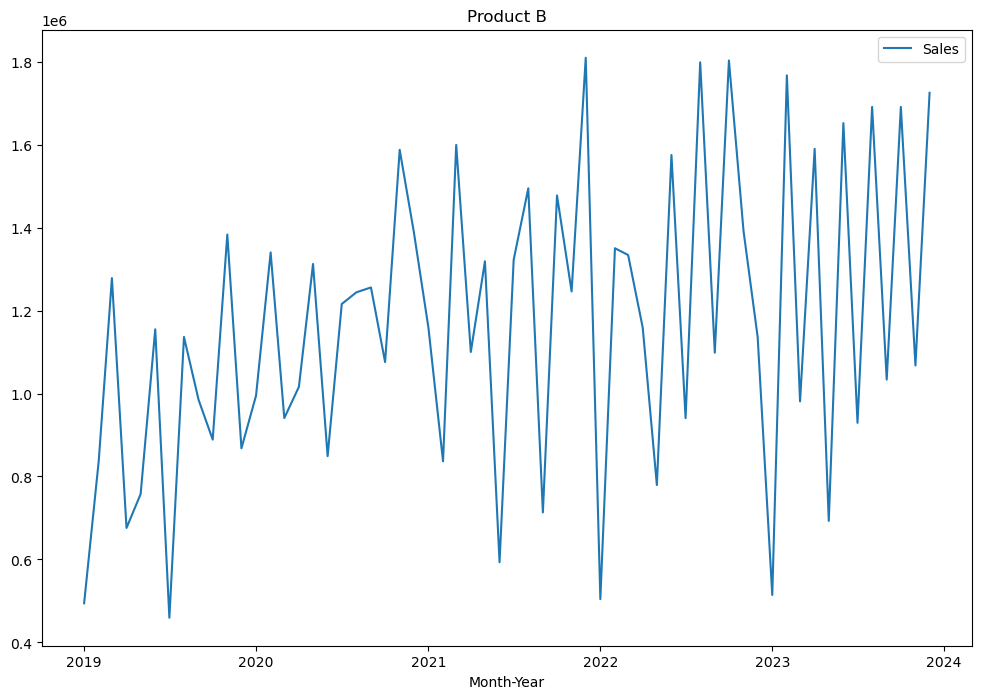

In [7]:
plt.figure(figsize=(12,8))
sns.lineplot(sales_b)
plt.title('Product B')

In [8]:
from statsmodels.tsa.stattools import adfuller

In [9]:
def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [10]:
adf_test(sales_b)

ADF Statistics: -2.263078907366476
p- value: 0.18415230168794178
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [11]:
sales_b_diff= sales_b.diff().dropna()

Text(0.5, 1.0, 'Product B - First Difference')

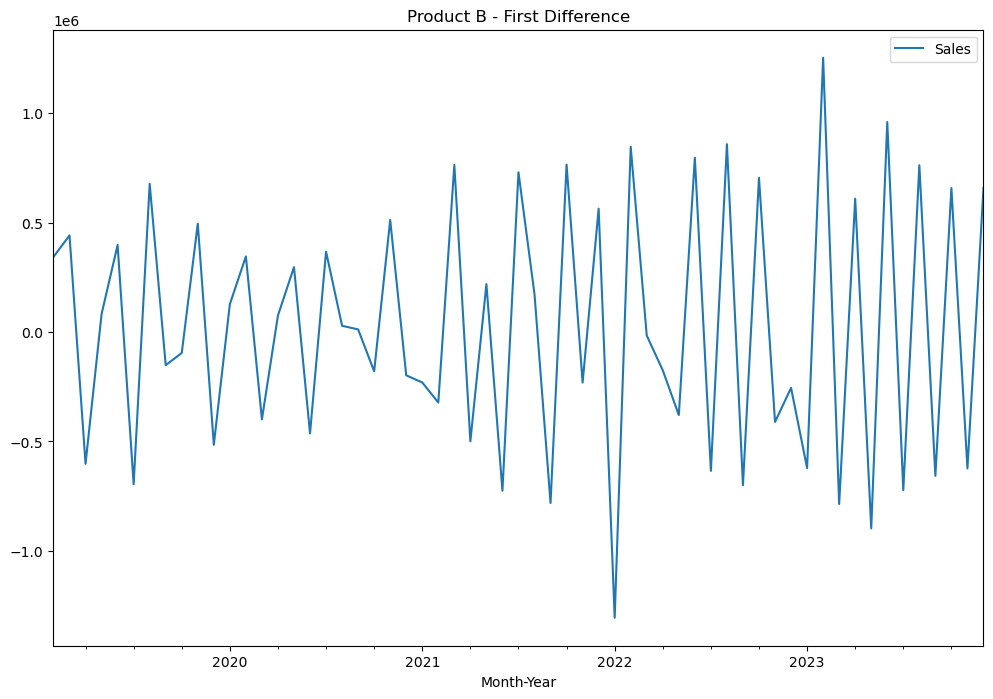

In [12]:
sales_b_diff.plot(figsize=(12,8))
plt.title('Product B - First Difference')

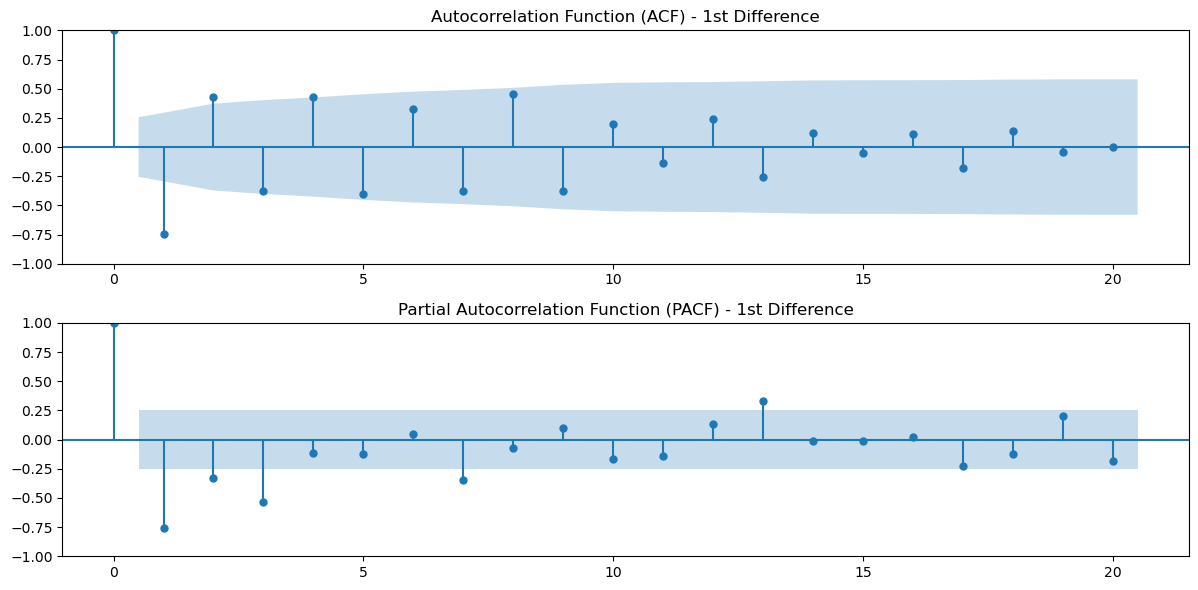

In [13]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(sales_b_diff, lags=20, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - 1st Difference')

plt.subplot(212)
plot_pacf(sales_b_diff, lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - 1st Difference')

plt.tight_layout()
plt.show()

In [14]:
adf_test(sales_b_diff)

ADF Statistics: -10.617041136124557
p- value: 5.639859315327351e-19
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [15]:
train= sales_b[:57]
test=sales_b[57:]

In [16]:
print(len(train),len(test))

57 3


In [17]:
#Finding the best value for ARIMA

#import itertools
#p=d=q=range(0,5)
#pdq = list(itertools.product(p,d,q))

#for param in pdq:
#    try:
#        model_arima = ARIMA(train,order=param)
#        model_arima_fit = model_arima.fit()
#       print(param,model_arima_fit.aic)
#    except:
#        continue
    
# The Akaike information criterion (AIC) is an estimator of in-sample prediction error and thereby relative quality of
# statistical models for a given set of data

# It's like the mean squared error in Regression - The smaller the number, the better

In [18]:
#therefore, the combination p=(0,1,2,3,4,5) d=1 q=(0,1,2,3) must be tested with accuracy metrics and aic

In [19]:
#param = [(0,1,0),(0,1,1),(0,1,2),(0,1,3),(1,1,0),(1,1,1),(1,1,2),(1,1,3),(2,1,0), (2,1,1), (2,1,2),(2,1,3),(3,1,0),(3,1,1),(3,1,2),(3,1,3),(4,1,0),(4,1,1),(4,1,2),(4,1,3),(5,1,0),(5,1,1),(5,1,2),(5,1,3)]

#for p in param:  # Changed 'x' to 'p'
#    model = ARIMA(train, order=p).fit()
#    pred = model.forecast(steps=len(test))
#    mae = mean_absolute_error(test, pred)
#    mape = np.mean(np.abs((test - pred) / test)) * 100
#    mse=mean_squared_error(test, pred)
#    rmse = np.sqrt(mean_squared_error(test, pred))
#    print(p)
#    print(f'MAE: {mae}')
#    print(f'MSE: {mse}')
#    print(f'RMSE: {rmse}')
#    print('A.I.C:', model.aic)

In [20]:
order=[]
for p in range(6):
    # Loop over MA order
    for q in range(4):
        # Fit model        
#       model= ARIMA(sales_b, order=(p,1,q))
        model_t = ARIMA(train['Sales'], order=(p,1,q))
        model_test=model_t.fit() 
        pred=model_test.predict(start=len(train), end=(len(sales_b)-1))
        mae = mean_absolute_error(test, pred)
        mape = np.mean(np.abs((test - pred) / test)) * 100
        mse=mean_squared_error(test, pred)
        rmse = np.sqrt(mean_squared_error(test, pred))
        # Add order and scores to list        
        order.append((p, q, model_test.aic, model_test.bic,mae, mse, rmse))
#Make DataFrame of model order and AIC/BIC scores
order_df = pd.DataFrame(order, columns=['p','q', 'aic', 'bic', 'mae','mse', 'rmse'])

In [21]:
# Sort by AIC
print(order_df.sort_values('aic'))

    p  q          aic          bic            mae           mse           rmse
11  2  3  1592.285109  1604.437220  186837.831709  3.913612e+10  197828.503579
12  3  0  1592.342848  1600.444254  125113.333373  2.032087e+10  142551.281947
13  3  1  1592.803078  1602.929837  189761.627779  4.569830e+10  213771.608653
7   1  3  1592.960189  1603.086948  148736.154713  2.922032e+10  170939.517656
16  4  0  1593.438242  1603.565000  169649.897469  3.485572e+10  186696.862992
19  4  3  1593.557229  1609.760043  184110.221117  5.364475e+10  231613.358594
14  3  2  1593.605621  1605.757731  141642.785113  2.381540e+10  154322.400320
6   1  2  1593.625624  1601.727030  135401.195535  2.193693e+10  148111.198081
5   1  1  1593.699746  1599.775801  299874.935180  1.041155e+11  322669.355774
17  4  1  1593.718595  1605.870705  164829.484388  3.810011e+10  195192.506113
10  2  2  1594.292032  1604.418791  139430.334324  2.467801e+10  157092.349404
20  5  0  1595.096521  1607.248631  147690.231077  2

In [22]:
m_arima= ARIMA(train, order=(2,1,3))
model_arima=m_arima.fit()
print(model_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   57
Model:                 ARIMA(2, 1, 3)   Log Likelihood                -790.143
Date:                Thu, 09 May 2024   AIC                           1592.285
Time:                        15:00:28   BIC                           1604.437
Sample:                    01-01-2019   HQIC                          1596.996
                         - 09-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1999      0.296     -0.675      0.500      -0.780       0.381
ar.L2          0.7276      0.251      2.893      0.004       0.235       1.220
ma.L1         -1.0184      0.294     -3.463      0.0

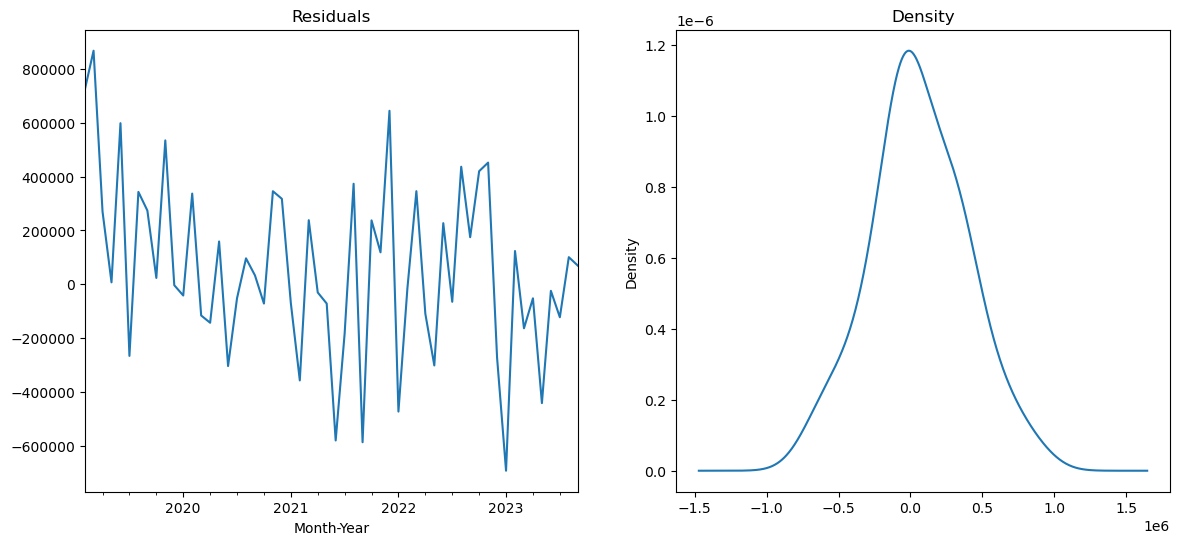

In [23]:
residuals= model_arima.resid[1:]
fig,ax=plt.subplots(1,2, figsize=(14, 6))
residuals.plot(title='Residuals',ax=ax[0])
residuals.plot(title='Density',kind='kde',ax=ax[1])
plt.show()

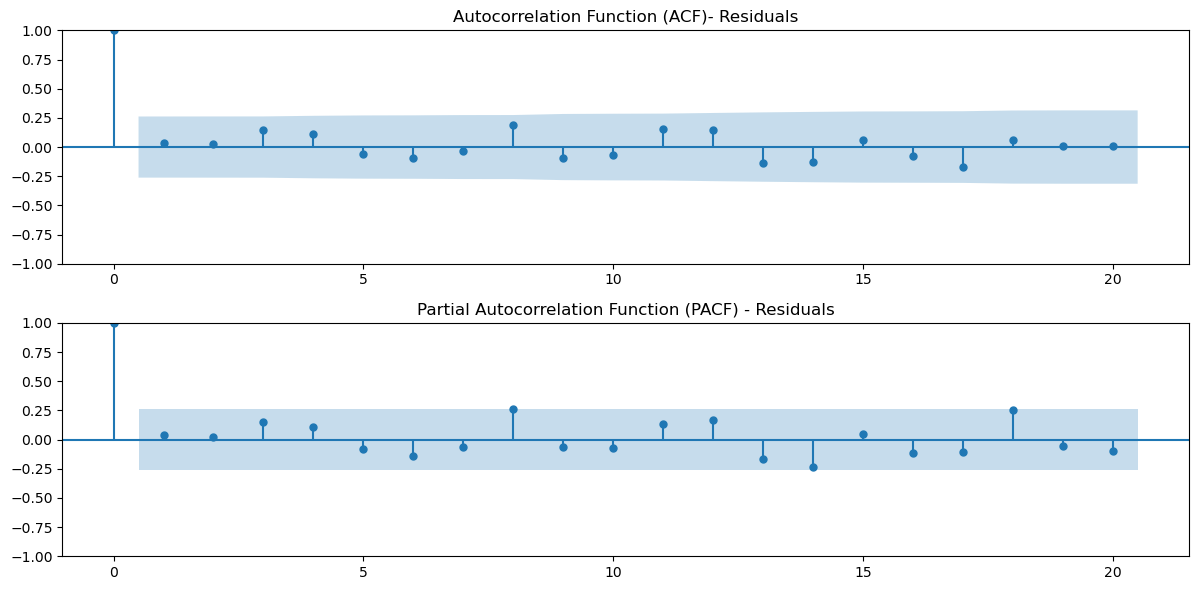

In [24]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(residuals, lags=20, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)- Residuals')

plt.subplot(212)
plot_pacf(residuals, lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Residuals')

plt.tight_layout()
plt.show()

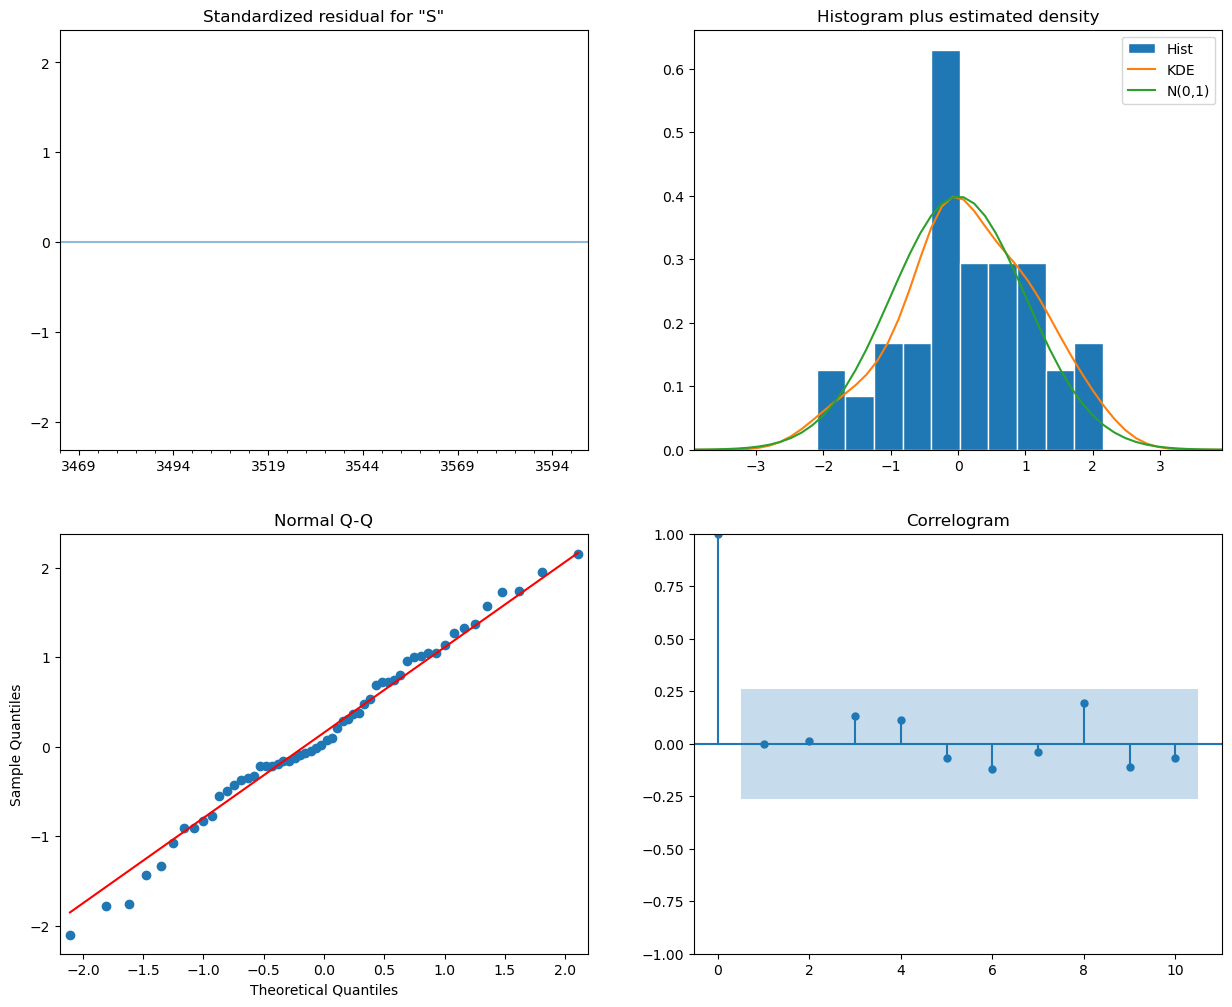

In [25]:
# Create the 4 diagostics plots
model_arima.plot_diagnostics(figsize=(15, 12))
plt.show()

In [26]:
#pred_in_sample = model_arima.get_prediction(start=len(train), end=(len(sales_b)-1))
#sales_b['Forecast_ARIMA_p']=[None]*len(train) + list(pred)

In [27]:
#plt.figure(figsize=(12, 8))
#sns.lineplot(sales_b[['Sales','Forecast_ARIMA_p']])
#plt.title('Product B')
#plt.show()

In [28]:
pred=model_arima.predict(start=len(train), end=(len(sales_b)-1), dynamic = True)
sales_b['Forecast_ARIMA']=[None]*len(train) + list(pred)
#sales_b.plot()

In [29]:
#pred=model_arima.forecast(steps= len(test))
#sales_b['Forecast_ARIMA']=[None]*len(train) + list(pred)
#sales_b.plot()

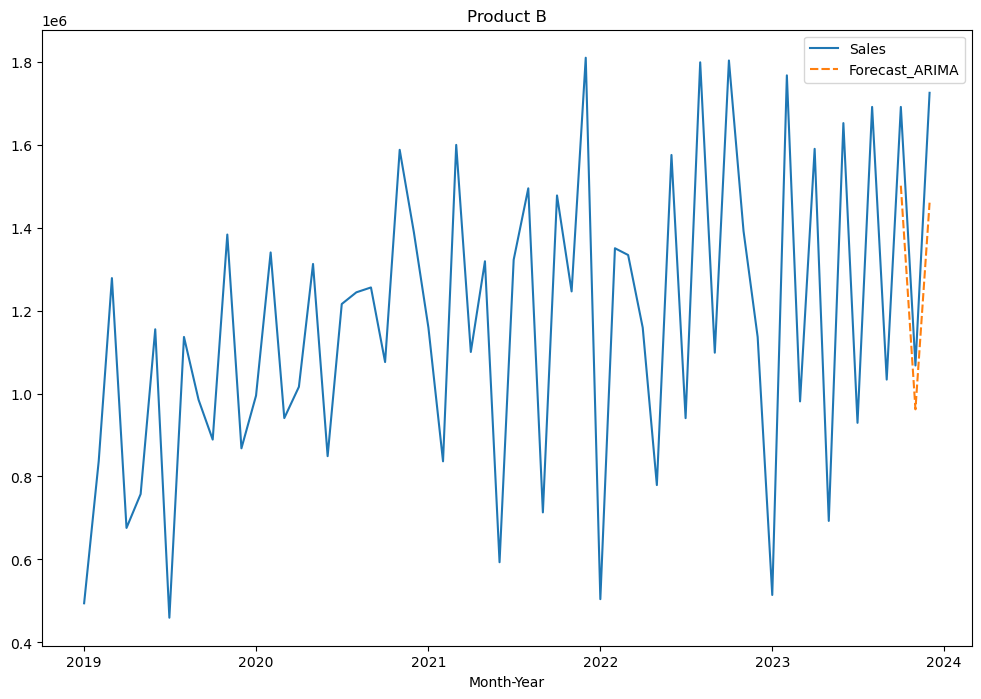

In [30]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_b[['Sales','Forecast_ARIMA']])
plt.title('Product B')
plt.show()

In [31]:
mae_arima= mean_absolute_error(test,pred)
mse_arima=mean_squared_error(test, pred)
mape_arima= mean_absolute_percentage_error(test,pred)
rmse_arima= np.sqrt(mean_squared_error(test,pred))

print(f'MAE - ARIMA: {mae_arima}')
print(f'MAPE - ARIMA: {mape_arima}')
print(f'MSE - ARIMA: {mse_arima}')
print(f'RMSE - ARIMA: {rmse_arima}')

MAE - ARIMA: 186837.8317094824
MAPE - ARIMA: 0.12163022501806471
MSE - ARIMA: 39136116828.356964
RMSE - ARIMA: 197828.50357912775


# FORECASTING

In [32]:
f_arima= ARIMA(sales_b['Sales'], order=(2,1,3))
model_f_arima=f_arima.fit()

In [33]:
forecast_=model_f_arima.predict(start=len(sales_b), end=(len(sales_b)+2), dynamic = True)

In [34]:
forecast_

2024-01-01    9.407310e+05
2024-02-01    1.540373e+06
2024-03-01    9.848604e+05
Freq: MS, Name: predicted_mean, dtype: float64

Text(0.5, 1.0, 'Product B')

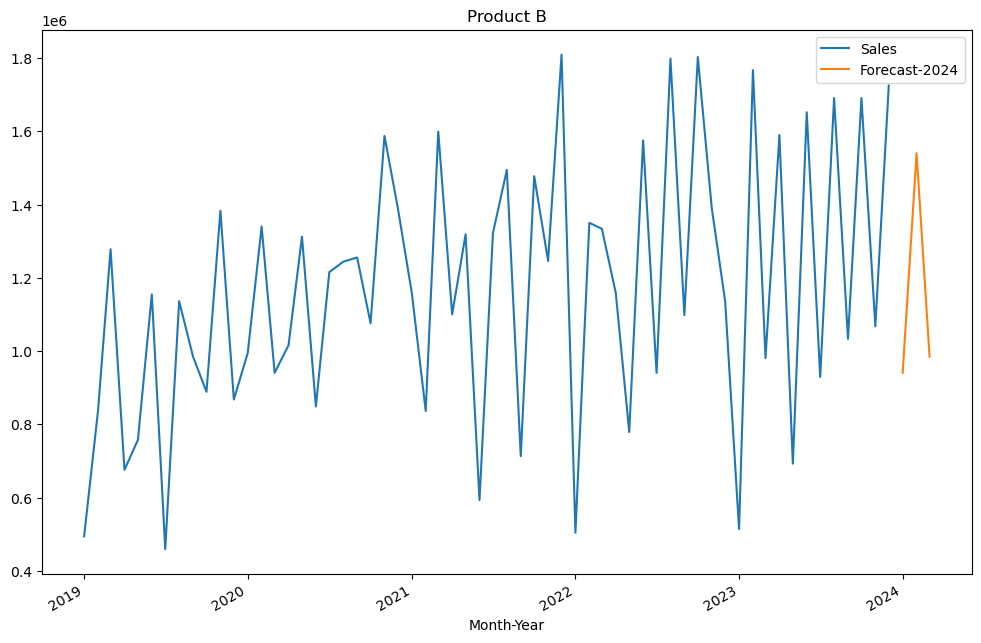

In [35]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_b[['Sales']])
forecast_.plot(legend=True, label='Forecast-2024')
plt.title('Product B')

In [36]:
arima_forecast_model=model_f_arima.get_forecast(steps=3)

In [37]:
mean_forecast= arima_forecast_model.predicted_mean
dates = mean_forecast.index

In [38]:
confidence_intervals= arima_forecast_model.conf_int()

In [39]:
print(mean_forecast,confidence_intervals)

2024-01-01    9.407310e+05
2024-02-01    1.540373e+06
2024-03-01    9.848604e+05
Freq: MS, Name: predicted_mean, dtype: float64               lower Sales   upper Sales
2024-01-01  311563.783085  1.569898e+06
2024-02-01  899541.575345  2.181205e+06
2024-03-01  333841.987683  1.635879e+06


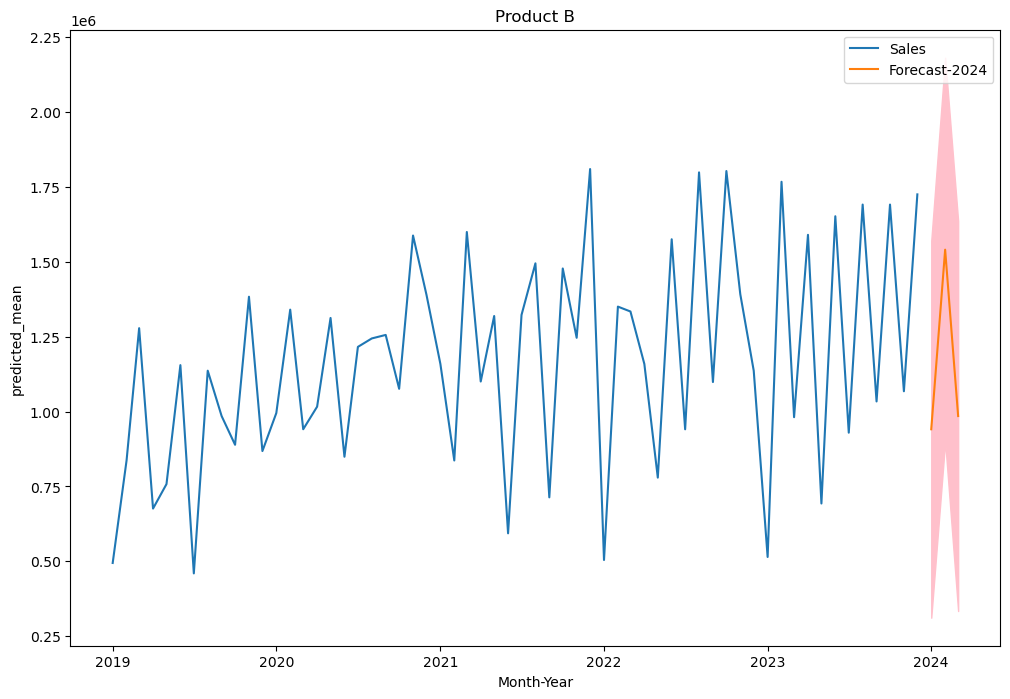

In [40]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_b[['Sales']])
sns.lineplot(mean_forecast,label='Forecast-2024')
#plt.plot(mean_forecast,color='red',label='Forecast-2024')
plt.fill_between(dates,confidence_intervals['lower Sales'],confidence_intervals['upper Sales'],color='pink')
plt.title('Product B')
plt.show()

# SARIMA

In [41]:
import statsmodels.api as sm

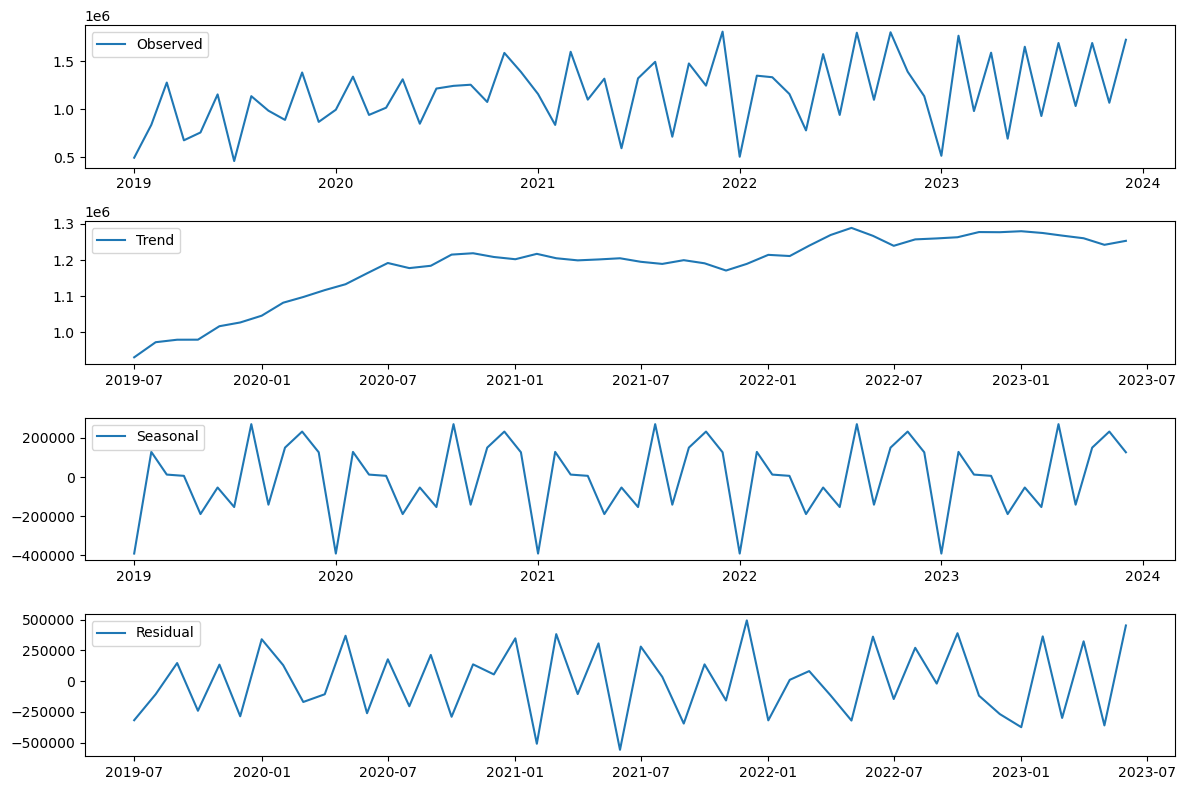

In [53]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition
decomposition = seasonal_decompose(sales_b['Sales'], period=12)

# Plot the decomposition
#fig = decomposition.plot(figsize=(12,8))
#plt.show()
# Create a new figure with the specified size
plt.figure(figsize=(12, 8))

# Plot each component separately
plt.subplot(411)
plt.plot(decomposition.observed, label='Observed')
plt.legend()

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend()

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend()

plt.subplot(414)
plt.plot(decomposition.resid, label='Residual')
plt.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

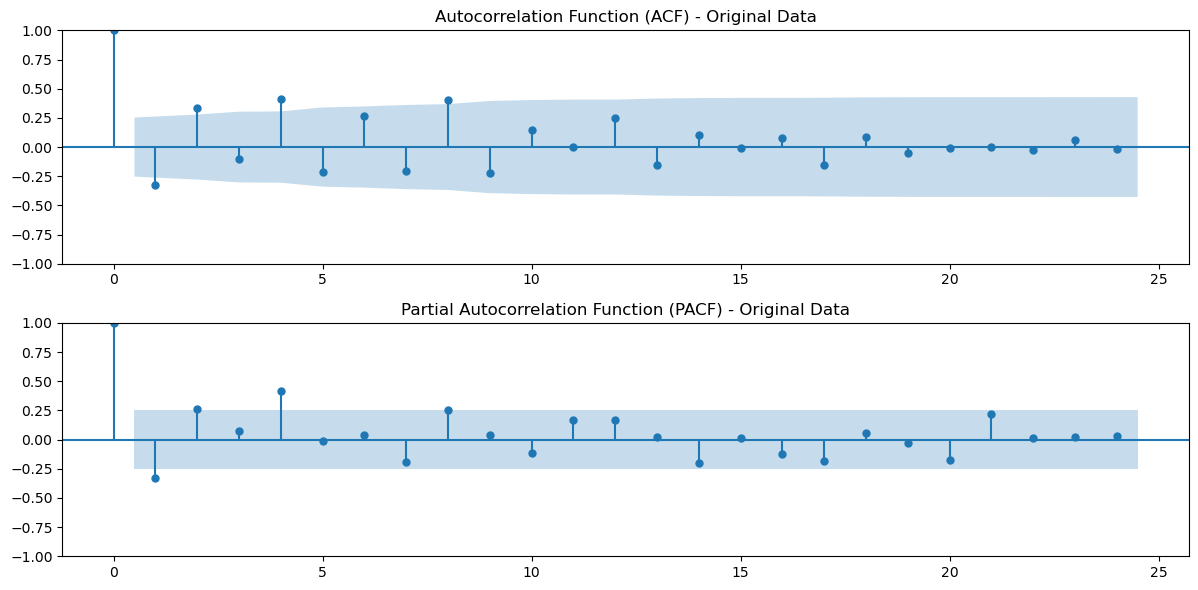

In [43]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(sales_b['Sales'], lags=24, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - Original Data')

plt.subplot(212)
plot_pacf(sales_b['Sales'], lags=24, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Original Data')

plt.tight_layout()
plt.show()

In [44]:
# Plot
#fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
#axes[0].plot(sales_b['Sales'], label='Original Series')
#axes[0].plot(sales_b['Sales'].diff(1), label='Usual Differencing')
#axes[0].set_title('Usual Differencing')
#axes[0].legend(loc='upper left', fontsize=10)


# Seasinal Dei
#axes[1].plot(sales_b['Sales'], label='Original Series')
#axes[1].plot(sales_b['Sales'].diff(12), label='Seasonal Differencing', color='green')
#axes[1].set_title('Seasonal Differencing')
#plt.legend(loc='upper left', fontsize=10)
#plt.suptitle('Product B', fontsize=16)
#plt.show()

In [45]:
# Plot ACF and PACF
#plt.figure(figsize=(12, 6))
#plt.subplot(211)
#plot_acf(sales_b['Sales'].diff(12).dropna(), lags=22, ax=plt.gca())
#plt.title('Autocorrelation Function (ACF) - Seasonal Difference')

#plt.subplot(212)
#plot_pacf(sales_b['Sales'].diff(12).dropna(), lags=22, ax=plt.gca())
#plt.title('Partial Autocorrelation Function (PACF) - Seasonal Difference')

#plt.tight_layout()
#plt.show()

In [86]:
order_SARIMAX=[]
# Loop over P order
for P in range(3):
    # Loop over Q order
    for Q in range(3):
        # Fit model
        model_s = sm.tsa.statespace.SARIMAX(train['Sales'], order=(2,1,3), seasonal_order=(P, 0, Q, 12))
        model_test_s = model_s.fit() 
        pred = model_test_s.predict(start=57, end=59, dynamic=True)
        mae = mean_absolute_error(test, pred)
        mse = mean_squared_error(test, pred)
        # Add order and scores to list        
        order_SARIMAX.append((P, Q, model_test_s.aic, model_test_s.bic, mae, mse))

# Make DataFrame of model order and scores
order_SARIMAX_df = pd.DataFrame(order_SARIMAX, columns=['P', 'Q', 'aic', 'bic', 'mae', 'mse'])


In [87]:
# Sort by AIC
print(order_SARIMAX_df.sort_values('aic'))

   P  Q          aic          bic            mae           mse
1  0  1  1590.428353  1604.605815  248421.081696  9.814704e+10
3  1  0  1591.216287  1605.393749  200311.287695  6.182003e+10
0  0  0  1592.285109  1604.437220  186837.831709  3.913612e+10
2  0  2  1592.402578  1608.605391  250044.475487  1.000355e+11
4  1  1  1592.402714  1608.605528  249752.035321  9.974223e+10
6  2  0  1592.753961  1608.956775  236245.371881  9.103444e+10
7  2  1  1594.399323  1612.627489  250977.938467  1.009960e+11
5  1  2  1594.402224  1612.630389  249832.515647  9.987746e+10
8  2  2  1595.807771  1616.061288  259282.284994  9.509947e+10


In [48]:
sarima=sm.tsa.statespace.SARIMAX(train['Sales'],order=(2,1,3),seasonal_order=(0,0,1,12))
sarima_model=sarima.fit()

In [51]:
sarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                Sales   No. Observations:                   57
Model:             SARIMAX(2, 1, 3)x(0, 0, [1], 12)   Log Likelihood                -788.214
Date:                              Thu, 09 May 2024   AIC                           1590.428
Time:                                      15:02:05   BIC                           1604.606
Sample:                                  01-01-2019   HQIC                          1595.925
                                       - 09-01-2023                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3319      0.594     -0.559      0.576      -1.496       0.832
ar.L2          0.4984      0.435      1.145      0.252      -0.355       1.352
ma.L1         -0.9245      0.592     -1.563      0.118      -2.084       0.235
ma.L2         -0.4406      0.520     -0.848      0.397      -1.459       0.578
ma.L3          0.5314      0.261      2.034      0.042       0.019       1.044
ma.S.L12       0.3958      0.230      1.724      0.085      -0.054       0.846
sigma2      1.086e+11   2.04e-12   5.33e+22      0.000    1.09e+11    1.09e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 1.19
Prob(Q):                              0.79   Prob(JB):                         0.55
Heteroskedasticity (H):               0.82   Skew:                            -0.24
Prob(H) (two-sided):                  0.68   Kurtosis:                         2.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.5e+40. Standard errors may be unstable.
"""

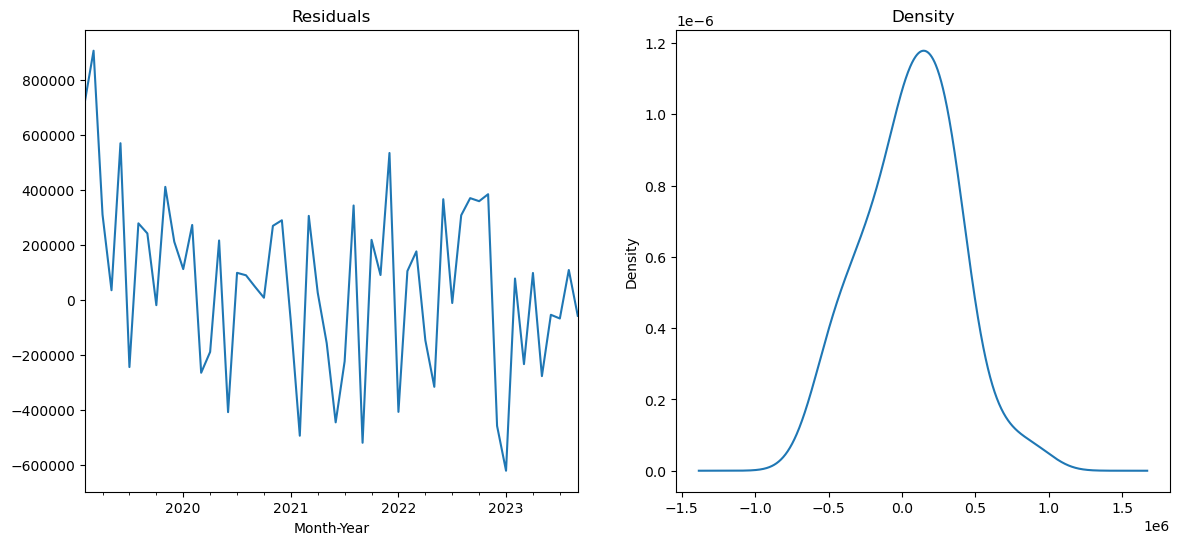

In [52]:
residuals_s= sarima_model.resid[1:]
fig,ax=plt.subplots(1,2, figsize=(14, 6))
residuals_s.plot(title='Residuals',ax=ax[0])
residuals_s.plot(title='Density',kind='kde',ax=ax[1])
plt.show()

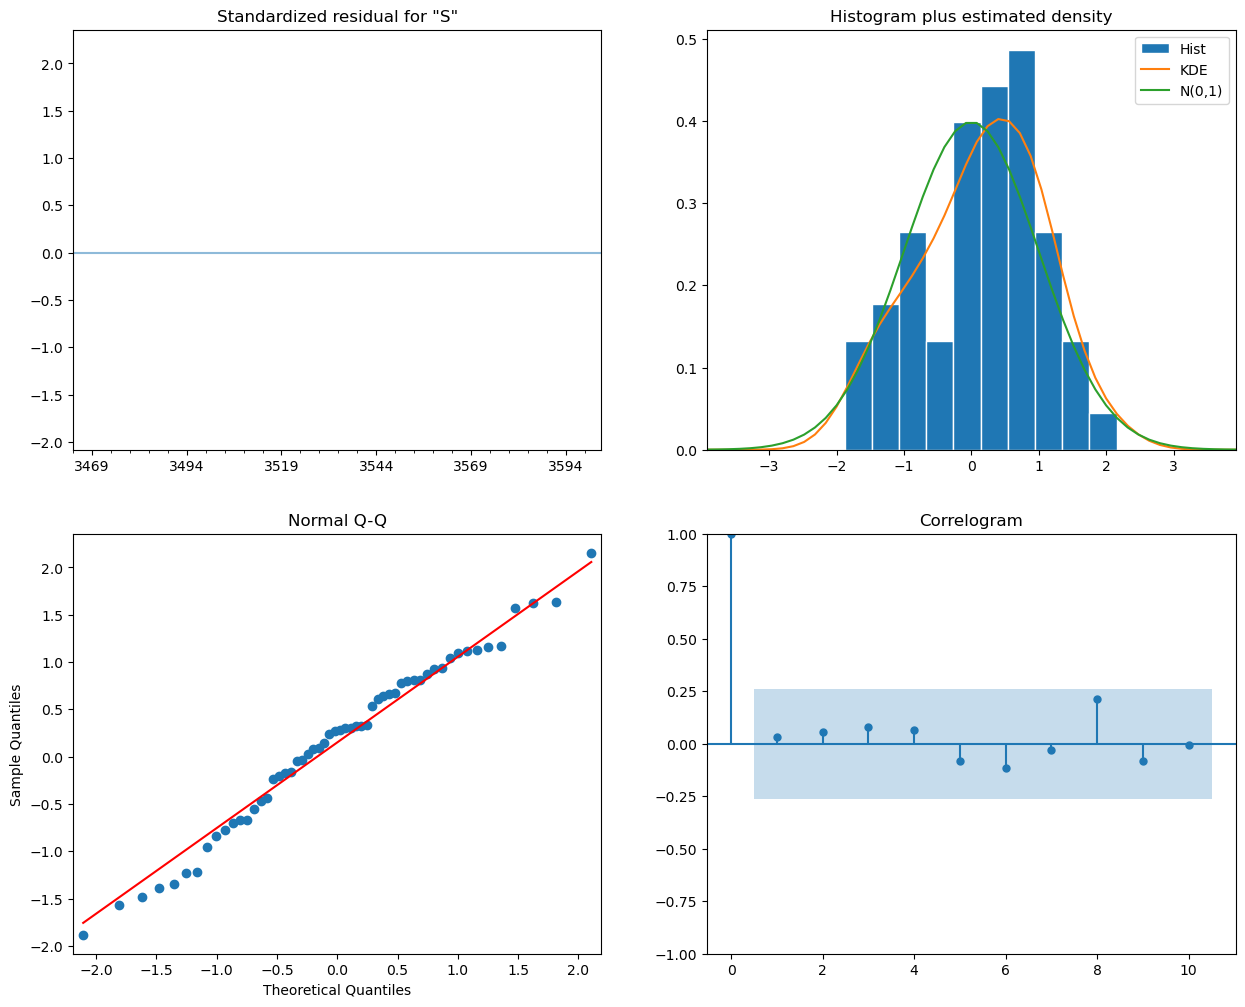

In [54]:
sarima_model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [55]:
forecast_test_sarima=sarima_model.predict(start=57,end=59,dynamic=True)

In [56]:
sales_b['Forecast_SARIMA']=[None]*len(train)+ list(forecast_test_sarima)
#sales_b[['Sales','Forecast_SARIMA']].plot(figsize=(12,8))

Text(0.5, 1.0, 'Product B')

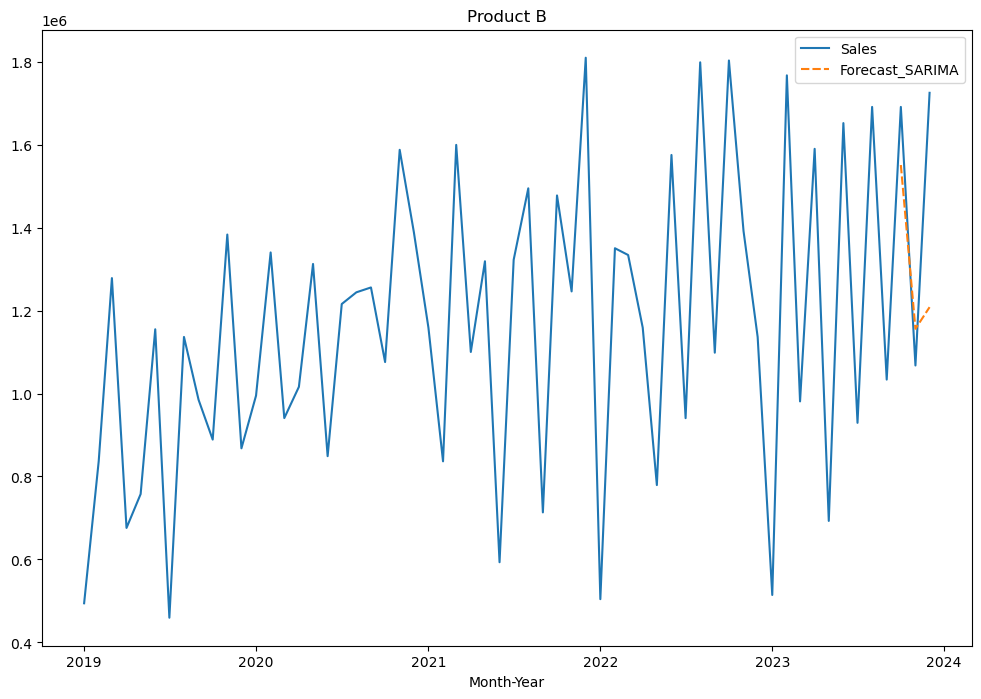

In [57]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_b[['Sales','Forecast_SARIMA']])
plt.title('Product B')

In [58]:
mae_sarima= mean_absolute_error(test,forecast_test_sarima)
mape_sarima= mean_absolute_percentage_error(test,forecast_test_sarima)
mse_sarima=mean_squared_error(test, forecast_test_sarima)
rmse_sarima= np.sqrt(mean_squared_error(test,forecast_test_sarima))

print(f'MAE - SARIMA: {round(mae_sarima,3)}')
print(f'MAPE - SARIMA: {round(mape_sarima,3)}')
print(f'MSE - SARIMA: {round(mse_sarima,3)}')
print(f'RMSE - SARIMA: {round(rmse_sarima,3)}')

MAE - SARIMA: 248421.082
MAPE - SARIMA: 0.155
MSE - SARIMA: 98147039349.201
RMSE - SARIMA: 313284.279


# FORECASTING

In [59]:
sarima_forecast=sm.tsa.statespace.SARIMAX(sales_b['Sales'],order=(2,1,3),seasonal_order=(0,0,1,12))
sarima_model_f=sarima_forecast.fit()

In [60]:
forecast_sarima=sarima_model_f.predict(start=60,end=62,dynamic=True)

In [61]:
forecast_sarima

2024-01-01    8.005975e+05
2024-02-01    1.643648e+06
2024-03-01    9.876189e+05
Freq: MS, Name: predicted_mean, dtype: float64

Text(0.5, 1.0, 'Product B')

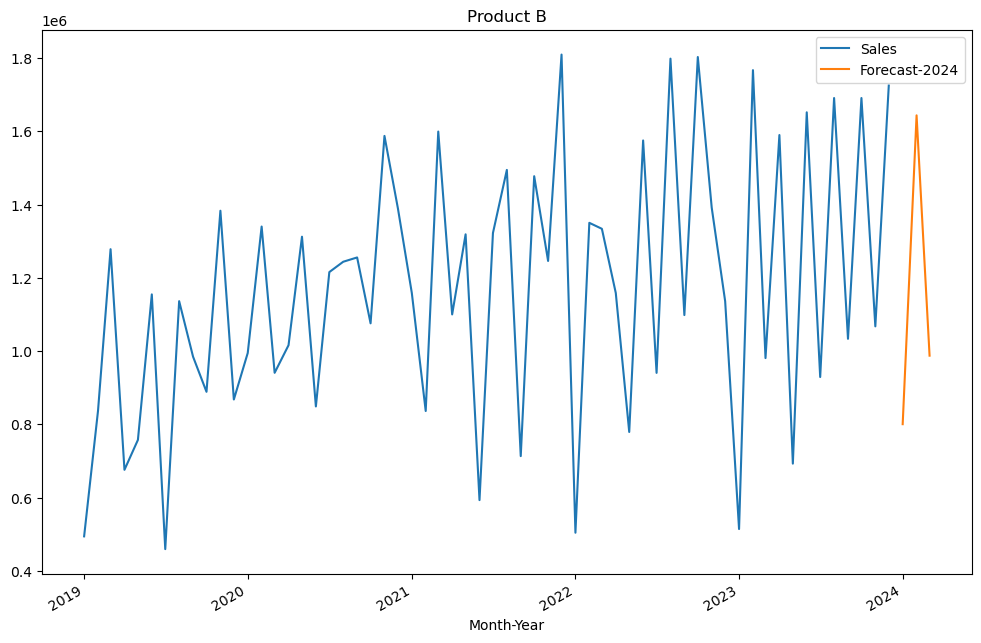

In [62]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_b[['Sales']])
forecast_sarima.plot(legend=True, label='Forecast-2024')
plt.title('Product B')

In [63]:
sarima_forecast_model=sarima_model_f.get_forecast(steps=3)

In [64]:
mean_forecast_sarima= sarima_forecast_model.predicted_mean
dates = mean_forecast_sarima.index

In [65]:
confidence_intervals_sarima= sarima_forecast_model.conf_int()

In [66]:
print(mean_forecast_sarima,confidence_intervals_sarima)

2024-01-01    8.005975e+05
2024-02-01    1.643648e+06
2024-03-01    9.876189e+05
Freq: MS, Name: predicted_mean, dtype: float64               lower Sales   upper Sales
2024-01-01  171689.870626  1.429505e+06
2024-02-01  996031.482979  2.291264e+06
2024-03-01  325883.750002  1.649354e+06


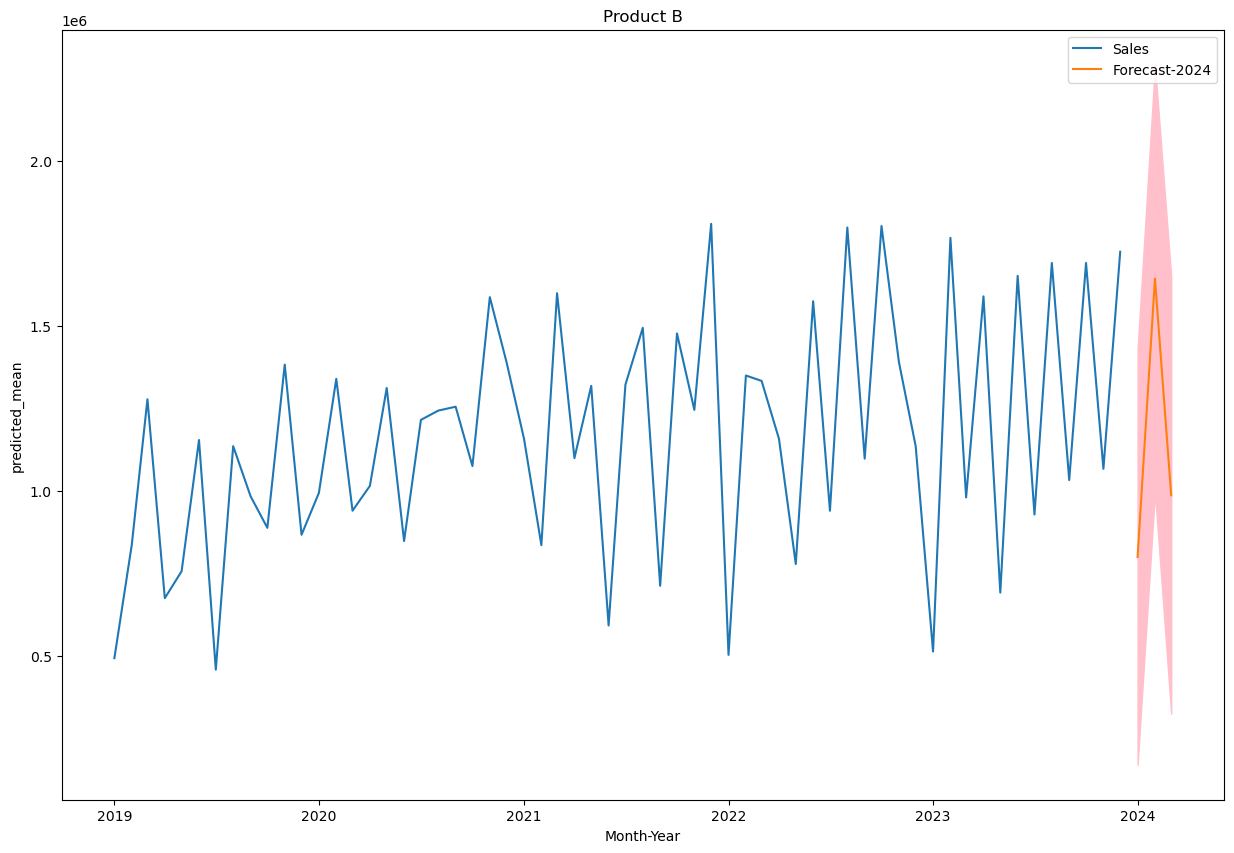

In [67]:
plt.figure(figsize=(15, 10))
sns.lineplot(sales_b[['Sales']])
sns.lineplot(mean_forecast_sarima,label='Forecast-2024')
#plt.plot(mean_forecast,color='red',label='Forecast-2024')
plt.fill_between(dates,confidence_intervals_sarima['lower Sales'],confidence_intervals_sarima['upper Sales'],color='pink')
plt.title('Product B')
plt.show()

# AUTO-ARIMA

In [68]:
import pmdarima as pm

In [69]:
auto_arima= pm.auto_arima(train, start_p=0, d=1, start_q=0, max_p=5,max_q=3,
                          start_P=0, D=0, start_Q=0, max_P=5 ,max_Q=5 ,  
                          stepwise=False, trace=True,
                          seasonal=True,m=12)
auto_arima

 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1649.336, Time=0.04 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1644.012, Time=0.06 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=1644.759, Time=0.20 sec
 ARIMA(0,1,0)(0,0,3)[12] intercept   : AIC=1646.733, Time=0.60 sec
 ARIMA(0,1,0)(0,0,4)[12] intercept   : AIC=1648.268, Time=1.85 sec
 ARIMA(0,1,0)(0,0,5)[12] intercept   : AIC=1650.268, Time=3.09 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1647.242, Time=0.06 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1645.054, Time=0.11 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=1646.748, Time=0.32 sec
 ARIMA(0,1,0)(1,0,3)[12] intercept   : AIC=1648.762, Time=0.68 sec
 ARIMA(0,1,0)(1,0,4)[12] intercept   : AIC=1650.268, Time=4.18 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=1645.858, Time=0.11 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=1646.484, Time=0.31 sec
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=1648.300, Time=0.58 sec
 ARIMA(0,1,0)(2,0,3)[12] intercept   : AIC=1650.219, Time=1.52

ARIMA(order=(1, 1, 1), scoring_args={}, seasonal_order=(0, 0, 1, 12),
      suppress_warnings=True)

In [70]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   57
Model:             SARIMAX(1, 1, 1)x(0, 0, 1, 12)   Log Likelihood                -789.001
Date:                            Thu, 09 May 2024   AIC                           1588.003
Time:                                    15:06:09   BIC                           1598.130
Sample:                                01-01-2019   HQIC                          1591.929
                                     - 09-01-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2.278e+04   1.44e+04      1.583      0.113   -5418.013     5.1e+04
ar.L1         -0.4812      0.167     -2.879      0.004      -0.809      -0.154
ma.L1         -0.8141      0.128     -6.347      0.000      -1.065      -0.563
ma.S.L12       0.4466      0.188      2.380      0.017       0.079       0.814
sigma2      1.075e+11      0.003   3.49e+13      0.000    1.08e+11    1.08e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):                 0.90
Prob(Q):                              0.60   Prob(JB):                         0.64
Heteroskedasticity (H):               1.09   Skew:                            -0.31
Prob(H) (two-sided):                  0.86   Kurtosis:                         3.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.19e+29. Standard errors may be unstable.
"""

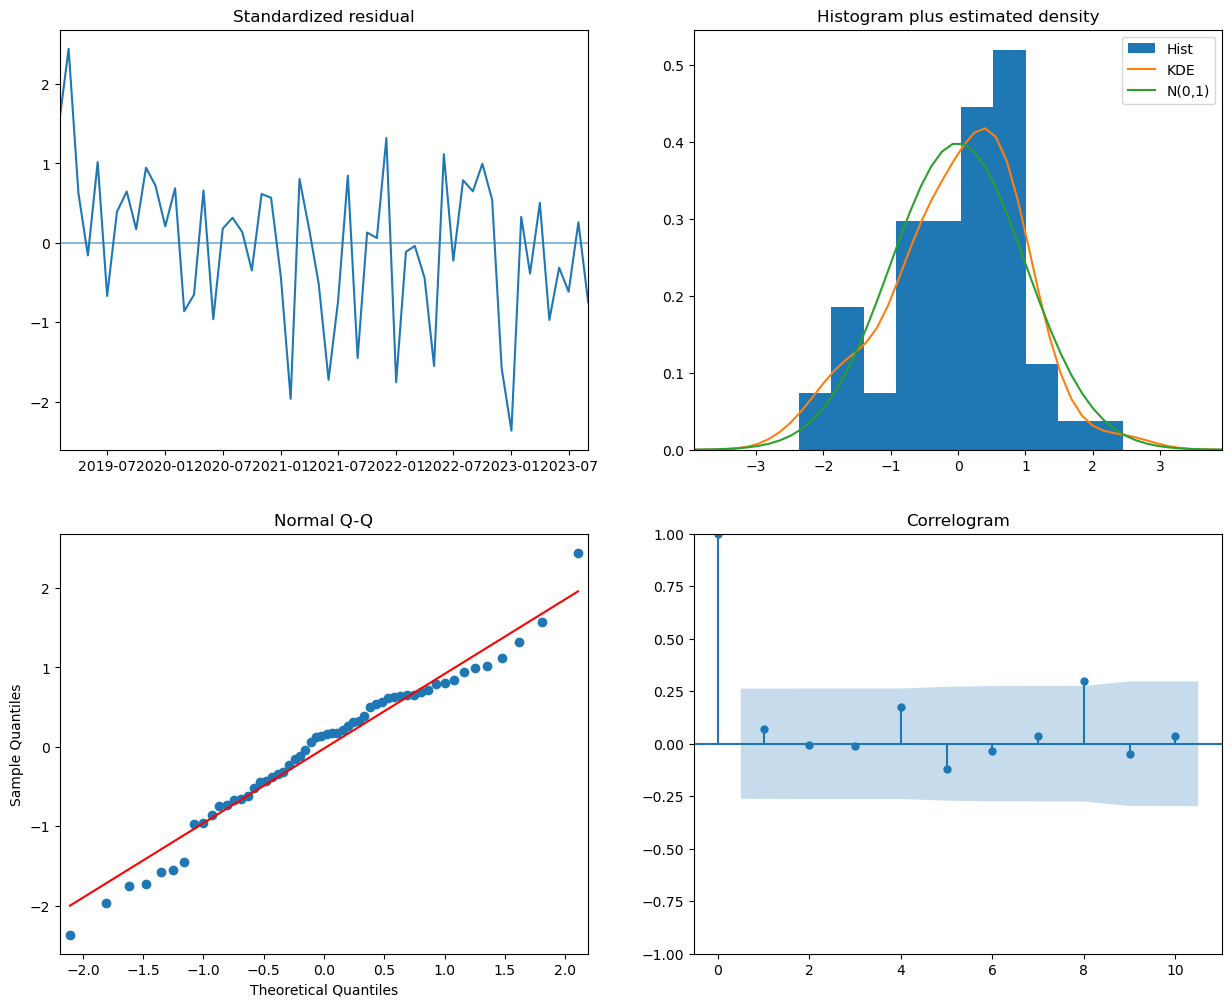

In [74]:
auto_arima.plot_diagnostics(figsize=(15, 12))
plt.show()

In [75]:
forecast_test_auto= auto_arima.predict(n_periods=len(test))
sales_b['Forecast_AUTO ARIMA']=[None]*len(train)+ list(forecast_test_auto)
#sales_b[['Sales','Forecast_AUTO ARIMA']].plot()

Text(0.5, 1.0, 'Product B')

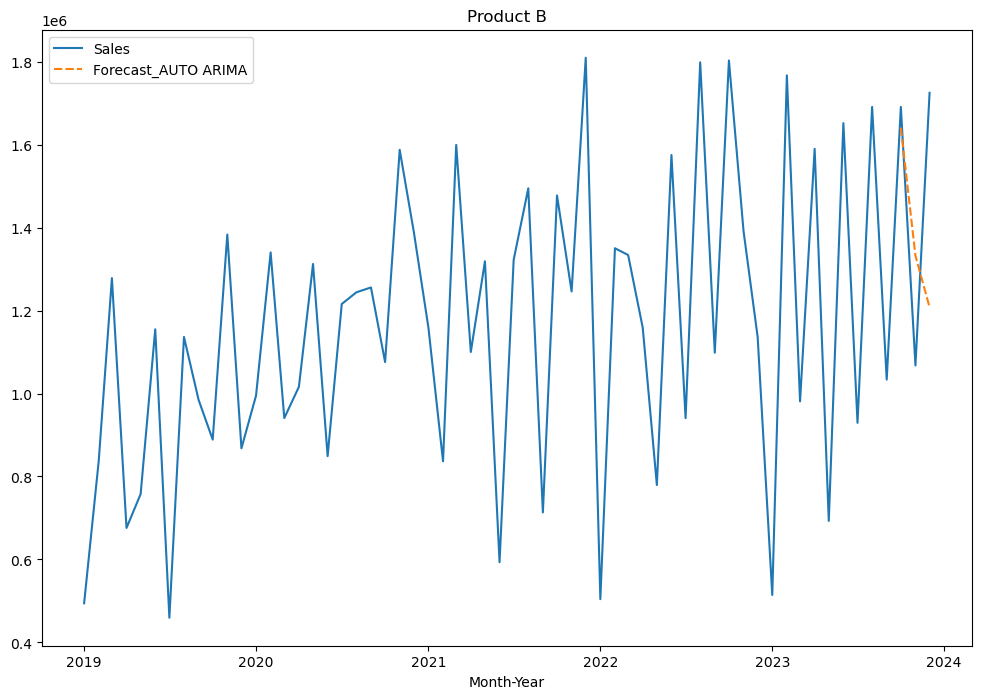

In [76]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_b[['Sales','Forecast_AUTO ARIMA']])
plt.title('Product B')

In [77]:
mae_auto_arima= mean_absolute_error(test,forecast_test_auto)
mape_auto_arima= mean_absolute_percentage_error(test,forecast_test_auto)
mse_auto_arima=mean_squared_error(test,forecast_test_auto)
rmse_auto_arima= np.sqrt(mean_squared_error(test,forecast_test_auto))

print(f'MAE - AUTO ARIMA: {mae_auto_arima}')
print(f'MAPE - AUTO ARIMA: {mape_auto_arima}')
print(f'MSE - AUTO ARIMA: {mse_auto_arima}')
print(f'RMSE - AUTO ARIMA: {rmse_auto_arima}')

MAE - AUTO ARIMA: 277237.8967275915
MAPE - AUTO ARIMA: 0.19241079770814884
MSE - AUTO ARIMA: 113279368846.03284
RMSE - AUTO ARIMA: 336570.00586212793


# FORECASTING

In [78]:
auto_arima_forecast= pm.auto_arima(sales_b['Sales'], start_p=0, d=1, start_q=0, max_p=5,max_q=3,
                          start_P=0, D=0, start_Q=0, max_P=5 ,max_Q=5 ,  
                          stepwise=False, trace=True,
                          seasonal=True,m=12)
auto_arima_forecast

 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1738.133, Time=0.03 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1733.214, Time=0.06 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=1734.693, Time=0.21 sec
 ARIMA(0,1,0)(0,0,3)[12] intercept   : AIC=1736.690, Time=0.60 sec
 ARIMA(0,1,0)(0,0,4)[12] intercept   : AIC=1738.654, Time=1.96 sec
 ARIMA(0,1,0)(0,0,5)[12] intercept   : AIC=1740.615, Time=3.17 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1735.306, Time=0.06 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1734.731, Time=0.12 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=1736.693, Time=0.35 sec
 ARIMA(0,1,0)(1,0,3)[12] intercept   : AIC=1738.681, Time=0.61 sec
 ARIMA(0,1,0)(1,0,4)[12] intercept   : AIC=1740.647, Time=4.21 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=1735.351, Time=0.11 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=1736.686, Time=0.29 sec
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=1738.664, Time=0.78 sec
 ARIMA(0,1,0)(2,0,3)[12] intercept   : AIC=1740.641, Time=2.26

ARIMA(order=(3, 1, 1), scoring_args={}, seasonal_order=(0, 0, 1, 12),
      suppress_warnings=True)

In [79]:
forecast_autoarima= auto_arima_forecast.predict(n_periods=3)

In [80]:
forecast_autoarima

2024-01-01    9.034068e+05
2024-02-01    1.663361e+06
2024-03-01    1.123630e+06
Freq: MS, dtype: float64

Text(0.5, 1.0, 'Product B')

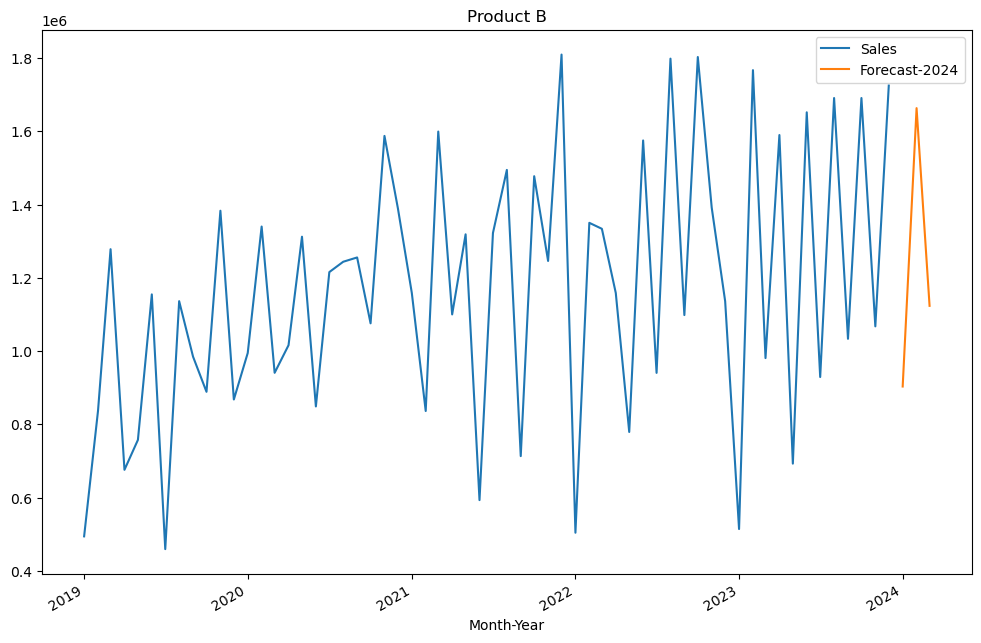

In [81]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_b[['Sales']])
forecast_autoarima.plot(legend=True, label='Forecast-2024')
plt.title('Product B')

In [82]:
sales_b.tail(3)

,Sales,Forecast_ARIMA,Forecast_SARIMA,Forecast_AUTO ARIMA
Month-Year,,,,
2023-10-01,1690948,1.501032e+06,1.550843e+06,1.640914e+06
2023-11-01,1067615,9.619060e+05,1.156064e+06,1.332315e+06
2023-12-01,1724948,1.460060e+06,1.208239e+06,1.207967e+06


In [83]:
sales_b.mean()

Sales                  1.166948e+06
Forecast_ARIMA         1.307666e+06
Forecast_SARIMA        1.305049e+06
Forecast_AUTO ARIMA    1.393732e+06
dtype: float64

In [84]:
data = {
    'model': ['ARIMA', 'AUTO ARIMA', 'SEASONAL ARIMA'],
    'MAE': [mae_arima, mae_auto_arima, mae_sarima],  
    'MAPE': [mape_arima, mape_auto_arima, mape_sarima],  
    'MSE': [mse_arima, mse_auto_arima, mse_sarima],  
    'RMSE': [rmse_arima, rmse_auto_arima, rmse_sarima]  
}

model_results = pd.DataFrame(data)
model_results.set_index('model', inplace=True)
model_results

,MAE,MAPE,MSE,RMSE
model,,,,
ARIMA,186837.831709,0.121630,3.913612e+10,197828.503579
AUTO ARIMA,277237.896728,0.192411,1.132794e+11,336570.005862
SEASONAL ARIMA,248421.081696,0.155085,9.814704e+10,313284.278810


# TESTING 

In [19]:
auto_arima_1= pm.auto_arima(train, start_p=0, start_q=0, max_p=5,max_q=3,
                          start_P=0, start_Q=0, max_P=2 ,max_Q=2 ,  
                          stepwise=False, trace=True,
                          seasonal=True,m=12)
auto_arima_1

 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1649.336, Time=0.04 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1644.012, Time=0.04 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=1644.759, Time=0.16 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1647.242, Time=0.07 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1645.054, Time=0.08 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=1646.748, Time=0.27 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=1645.858, Time=0.12 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=1646.484, Time=0.22 sec
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=1648.300, Time=0.35 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1606.755, Time=0.06 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1601.385, Time=0.05 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=1603.350, Time=0.20 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=1605.950, Time=0.07 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=1602.480, Time=0.11 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=inf, Time=0.66 sec


ARIMA(order=(1, 1, 1), scoring_args={}, seasonal_order=(0, 0, 1, 12),
      suppress_warnings=True)

In [20]:
auto_arima_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   57
Model:             SARIMAX(1, 1, 1)x(0, 0, 1, 12)   Log Likelihood                -789.001
Date:                            Wed, 08 May 2024   AIC                           1588.003
Time:                                    18:21:03   BIC                           1598.130
Sample:                                01-01-2019   HQIC                          1591.929
                                     - 09-01-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2.278e+04   1.44e+04      1.583      0.113   -5418.013     5.1e+04
ar.L1         -0.4812      0.167     -2.879      0.004      -0.809      -0.154
ma.L1         -0.8141      0.128     -6.347      0.000      -1.065      -0.563
ma.S.L12       0.4466      0.188      2.380      0.017       0.079       0.814
sigma2      1.075e+11      0.003   3.49e+13      0.000    1.08e+11    1.08e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):                 0.90
Prob(Q):                              0.60   Prob(JB):                         0.64
Heteroskedasticity (H):               1.09   Skew:                            -0.31
Prob(H) (two-sided):                  0.86   Kurtosis:                         3.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.19e+29. Standard errors may be unstable.
"""

In [21]:
forecast_test_auto_1= auto_arima_1.predict(n_periods=len(test))
sales_b['Forecast_AUTO ARIMA_1']=[None]*len(train)+ list(forecast_test_auto_1)

Text(0.5, 1.0, 'Product B')

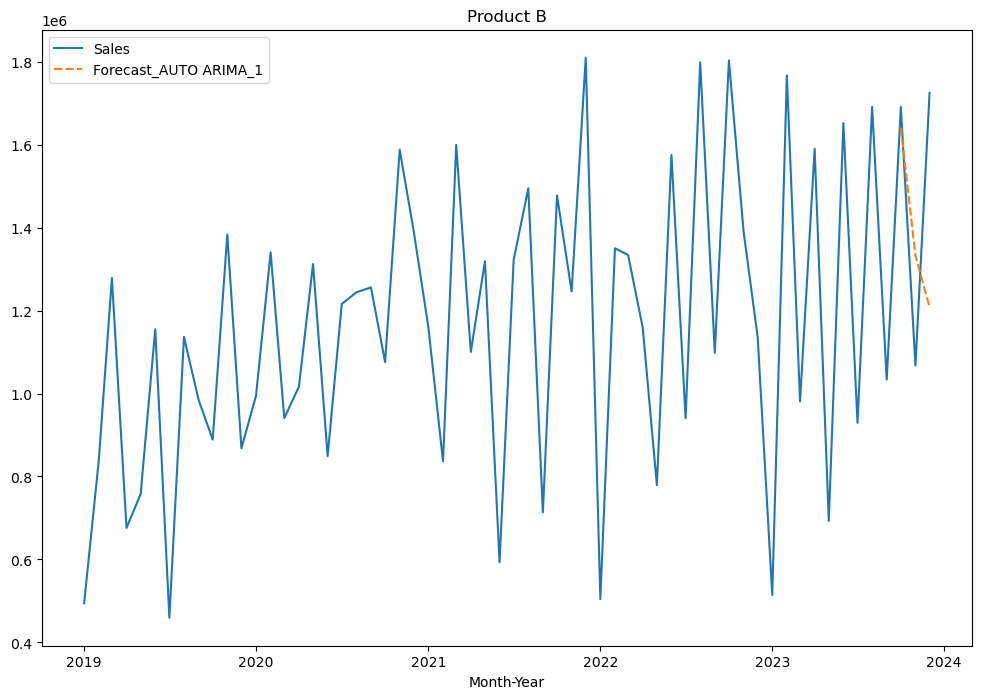

In [22]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_b[['Sales','Forecast_AUTO ARIMA_1']])
plt.title('Product B')

In [23]:
mae_auto_arima_1= mean_absolute_error(test,forecast_test_auto_1)
mape_auto_arima_1= mean_absolute_percentage_error(test,forecast_test_auto_1)
mse_auto_arima_1=mean_squared_error(test,forecast_test_auto_1)
rmse_auto_arima_1= np.sqrt(mean_squared_error(test,forecast_test_auto_1))

print(f'MAE - AUTO ARIMA: {mae_auto_arima_1}')
print(f'MAPE - AUTO ARIMA: {mape_auto_arima_1}')
print(f'MSE - AUTO ARIMA: {mse_auto_arima_1}')
print(f'RMSE - AUTO ARIMA: {rmse_auto_arima_1}')

MAE - AUTO ARIMA: 277237.8967275915
MAPE - AUTO ARIMA: 0.19241079770814884
MSE - AUTO ARIMA: 113279368846.03284
RMSE - AUTO ARIMA: 336570.00586212793
